# <center> Introduction à Julia </center>
Bienvenue dans ces travaux pratiques concernant *Julia* <br>
Pour entrer des commandes, tu te places sur une case et tu valides avec la combinaison  `<Shift-Enter>`  par exemple

In [16]:
2+2

4

Ou bien aussi

In [17]:
using LinearAlgebra
a = Matrix(I,3,3)

3×3 Matrix{Bool}:
 1  0  0
 0  1  0
 0  0  1

## Aide contextuelle
Pour obtenir de la documentation , tu peux à tout moment utiliser le symbole `?` dans une case

In [18]:
?zeros

search: zeros count_zeros set_zero_subnormals get_zero_subnormals leading_zeros



```
zeros([T=Float64,] dims::Tuple)
zeros([T=Float64,] dims...)
```

Create an `Array`, with element type `T`, of all zeros with size specified by `dims`. See also [`fill`](@ref), [`ones`](@ref), [`zero`](@ref).

# Examples

```jldoctest
julia> zeros(1)
1-element Vector{Float64}:
 0.0

julia> zeros(Int8, 2, 3)
2×3 Matrix{Int8}:
 0  0  0
 0  0  0
```


## Définir une fonction 
  Avant toute chose, voyons comment écrire une fonction : on peut utiliser
  le mot-clef `function`

In [19]:
function f(x)
    return sin(x+1)
end

f (generic function with 1 method)

Ou l'opérateur d'affectation `=`

In [20]:
f2(x) = sin(x+1)

f2 (generic function with 1 method)

, qui peut également être utilisé avec de multiple expressions (compound expressions)

In [21]:
f3(x) = begin
    sin(x+1)  # le mot clé `return` est optionnel
end

f3 (generic function with 1 method)

ou encore l'operateur `->` pour une fonction anonyme

In [22]:
f4 = x -> sin(x+1)

#18 (generic function with 1 method)

On peut *annoter* une fonction selon le *type* des arguments qu'elle prend

In [23]:
"""
puiss(x::Number, n::Int)

calcule la puissance d'un nombre
"""
function puiss(x::Number, n::Int) 
    s = 1.
    for i = 1:abs(n)
        s *= ( n > 0 ? x : 1. / x )
    end
    s
end

puiss

In [24]:
puiss(2., 2)

4.0

In [25]:
puiss(2., -2)

0.25

Par contre si on essaye avec un second argument flottant

In [26]:
puiss(2, 4.5)

LoadError: MethodError: no method matching puiss(::Int64, ::Float64)

[0mClosest candidates are:
[0m  puiss(::Number, [91m::Int64[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[23]:6[24m[39m


In [27]:
puiss(x::Float64, n::Float64) = exp(n * log(abs(x)))

puiss (generic function with 2 methods)

In [28]:
puiss(2.,4.5)

22.62741699796952

On peut alors lister les fonctions `puiss` grâce à la fonction `methods`

In [29]:
methods(puiss)

# 2 methods for generic function "puiss" from Main:
 [1] puiss(x::Number, n::Int64)
     @ In[23]:6
 [2] puiss(x::Float64, n::Float64)
     @ In[27]:1

## Tester une fonction
Pour écrire des fonctions les moins «buggées» possibles, on peut écrire
des tests unitaires grace au paquet `Test`

In [30]:
using Test
@test 1 == 2

Test Failed at In[30]:2
  Expression: 1 == 2
   Evaluated: 1 == 2



LoadError: [91mThere was an error during testing[39m

In [31]:
@test 1 == 1

Test Passed

In [32]:
@test puiss(2, 3) == 8

Test Passed

In [33]:
@test puiss(√2, 2) ≈ 2 atol=1e-12

Test Passed

# Syntaxe

La syntaxe est similaire à celle de MATLAB/Octave.

In [34]:
a = rand(2, 3, 4);  # alloue un tableau 3D de dimensions 2×3×4, et le remplit de nombre aléatoires

La syntaxe `b = 1 .+ sin.(sqrt.(a))` (condensée en utilisant la macro `@.`) permet de vectorizer l'opération `1 + sin(sqrt(x))`

In [35]:
b = @. 1 + sin(sqrt(a));

# Résolution numérique de l'équation de la chaleur

$\newcommand{\R}{\mathbb{R}}$
On va tout d'abord étudier différentes manières de calculer un laplacien en différences finies
   sur le carré $\Omega = [0,1]^2$. </br> En réalité, on ne va travailler que sur l'intérieur $\stackrel{o}{\Omega}$.
   On considère une fonction $u :  \Omega \rightarrow \R$, que l'on souhaite approcher par ses valeurs
   $$
   U_{i,j} = u(ih,jh) \mbox{ pour } i,j=0,\cdots,n+1
   $$
   avec $h=\frac{1}{n+1}$. On considérera - {\em abusivement} - $U$ comme une matrice ou un vecteur - noté $u$ - de
   $\R^{(n+2)^2}$ ou de $\R^{n\times n}$ en considérant que $u$ est nulle sur les bords
   $$
   u(x,y) = 0  \qquad \forall (x,y) \in \overline{\Omega}
   $$
   ce qui se traduit par
   $$
   U_{0,i} = U_{n+1,i} = U_{i,0} = U_{i,n+1} = 0  \mbox{ pour } i=0,\cdots, n+1
   $$
 Pour discrétiser le laplacien sur une grille régulière on va utiliser l'approximation suivante, 
    basée sur un développement limité
    \begin{eqnarray*}\label{Chal}
\Delta u(x,y) & \approx & \frac{u(x-h_x, y) + u(x+ h_x, y) - 2 u(x,y)}{h^2} \\
              & + & \frac{u(x, y-h_y) + u(x, y + h_y) - 2 u(x,y)}{h^2}, 
\end{eqnarray*}

   Graphiquement, cela correspondera à appliquer le pochoir(«stencil») suivant

<img src="stencil.svg">

  à l'intérieur d'une matrice avec les coefficients $d = -4/h^2$ , $w_x = w_y = 1/h^2$ 
  
<img src="buffer.svg">
 
## Algèbre linéaire dense

 En première approche, on peut calculer $\Delta u$ comme une matrice dense d'ordre $n^2$. L'ordre
 choisi pour déplier une matrice $n \times n$ en un vecteur de $\R^{n^2}$ est celui du Fortran, c'est à dire colonne par colonne. En *Julia*, on peut utiliser la fonction `vec` </br>
 Si on considère la matrice tridiagonale  
$$
K_n = \begin{pmatrix}
	2       & -1      & {\bf 0} \\
       -1      &  \ddots & -1 \\
       {\bf 0} & -1      & 2 \\
       \end{pmatrix},
$$

alors le laplacien 2D peut se construire sous de la façon suivante $\Delta u = -\frac{1}{h^2} K2D_n$ avec

$$
K2D_n =  K_n \otimes I_n + I_{n} \otimes  K_n.
$$
### Questions
 - Faire une fonction `K1D` qui prend un entier `n` en argument et construit la matrice $K_n$ (indice : on pourra utiliser `diagm` ou `Tridiagonal`
 - verifier que les 3 tests suivants passent
 ```julia
@test norm(diag(K1D(3)) - 2ones(3)) ≈ 0 atol=1e-12
@test norm(diag(K1D(3), -1) + ones(2)) ≈ 0 atol =1e-12
@test norm(diag(K1D(4), 1) + ones(3))  ≈ 0 atol=1e-12
```
 - coder les fonctions `v1D(n)` et `val1D(n)` qui calculent respectivement
$$
    V^n_{k,l} =  \sin \left( \frac{kl\pi}{n+1} \right) \forall (k,l) \in \{1,\cdots,n\}^2 \mbox{ et }  \lambda^n_k =  2 - 2 \cos \left( \frac{k\pi}{n+1} \right)
$$
des vecteurs propres de $K_n$ et ses valeurs propres</br>
`v1D(n)` renverra une matrice et `val1D(n)` un vecteur.</br> 
Attention, `sin` et `sin.` sont differents si on les appliquent à une matrice
- vérifier que  $\|K(n) V_1^n -\lambda_1^n  * V_1^n\| < \varepsilon$ en rajoutant le test suivant</br>
```julia
@test norm(val1D(3)[1] * v1D(3)[:, 1] - K1D(3) * v1D(3)[:, 1]) ≈ 0 atol=1e-10
```
- vérifier que $V$ est une matrice orthogonale avec le test suivant
 ```julia
n=3; V=v1D(n);
aI=V*V'
@test norm(aI-aI[1,1]*Matrix(I,3,3)) ≈ 0 atol=1e-12
```
 - coder une fonction `K2D` qui construit $K2D_n$; penser à utiliser `kron`
 - implanter la généralisation du test précédent
    $$
\|K2D_n \left( V^n_{\cdot,1} \otimes V^n_{\cdot,2} \right) - 
(\lambda^n_1 + \lambda^n_2)   \left( V^n_{\cdot,1} \otimes V^n_{\cdot,2} \right)\| < \varepsilon.
    $$
    avec 
```julia
v₁₁ = vec(v1D(3)[1, :] * v1D(3)[2, :]')
@test norm(K2D(3) * v₁₁ - sum(val1D(3)[1:2]) * v₁₁) ≈ 0 atol=1e-12
```

In [36]:
K1D(n::Int) = diagm(0 => 2ones(n), 1 => -ones(n - 1), -1 => -ones(n - 1))

val1D(n::Int) = 2 .- 2*cos.((1:n) * π / (n + 1))
    
v1D(n::Int) = sin.((1:n) * (1:n)' * π / (n + 1)) 


v1D (generic function with 1 method)

In [37]:
@test norm(val1D(3)[1] * v1D(3)[:,1] - K1D(3) * v1D(3)[:,1]) ≈ 0 atol=1e-10
n = 3; V = v1D(n);
aI = V * V'
@test norm(aI - aI[1, 1] * Matrix(I, 3, 3)) ≈ 0 atol=1e-12

Test Passed

In [38]:
K2D(n::Int) = (kron(K1D(n), Matrix(I, n, n)) + kron(Matrix(I, n, n), K1D(n)))

v₁₁ = vec(v1D(3)[1, :] * v1D(3)[2, :]')
@test norm(K2D(3) * v₁₁ - sum(val1D(3)[1:2]) * v₁₁) ≈ 0 atol=1e-12

Test Passed

## Algèbre linéaire creuse 
 Au lieu de considérer $\Delta u$ comme une matrice dense, on peut : 
  - soit implanter l'opérateur linéaire $\Delta : u \mapsto \Delta u$, directement comme une 
    endormorphisme de l'espace des matrices (version *a la mano*) 
  - soit utiliser le format creux SparseMatrixCSC
   
### *A la mano*
 - L'idée est de construire une fonction - appelons la temporairement $f$ - qui réalise le produit 
«matrice-vecteur»
\begin{eqnarray*}
    f : \R^{n^2} &\rightarrow & \R^{n^2} \\
              x & \mapsto & K2D(n)x.
\end{eqnarray*} 
avec $x = {\mathrm vec}(X)$ que l'on peut calculer grâce à `x = vec(X[2:end-1,2:end-1])`,
en admettant que $X$ soit de dimension $n+2$ et contienne des zéros sur le bord.
Cela revient en définitive à calculer une matrice $Y$ de même taille que $X$ telle que
$$
Y_{i,j} = 4 X_{i,j} - X_{i-1,j} - X_{i+1,j} -X_{i,j-1} - X_{i,j+1} \mbox{ pour } i,j=2,\cdots,n+1
$$

Pour résoudre un tel système, on fera typiquement appel à une méthode itérative (CG, GMRES, etc..),
car le propre de ces méthodes est de ne pas construire explicitement la matrice de l'opérateur
mais juste de l'évaluer contre des vecteurs choisis au cours des itérations. Par rapport,
aux constructions précédentes, on va considérer que l'objet d'entrée de notre fonction est 
une matrice carrée d'ordre $n+2$ et qu'elle renverra une matrice de même dimension, dont 
les *indices internes* contiennent le laplacien discret 2D de la matrice d'entrée.
    
#### Questions
       
 - coder une fonction `K2Dₗₒₒₚ(X)` qui prend en entrée une matrice $X$ d'ordre $n+2$ et 
     renvoie une matrice du même ordre dont les indices internes ($\{2,\cdots,n+1\}$) contiennent 
     $K2D(x)$ 
 - coder la même fonction `K2Dₘₐₙₒ` sans boucle (optionel)  
 - Vérifier que l'on trouve le même résultat qu'avec `K2D`
```julia
N = 5
u = range(0, 1; length=N)
Xᵢₙ = .√u*u'.^3
Xᵢₙ[1,:] .= 0;Xᵢₙ[end, :] .= 0; Xᵢₙ[:, end] .= 0; Xᵢₙ[:, 1] .= 0;
@test norm(vec(K2Dₛₚₐᵣₛₑ(Xᵢₙ)[2:end-1, 2:end-1]) -  K2D(N-2) * vec(Xᵢₙ[2:end-1, 2:end-1])) ≈ 0 atol=1e-12
```

In [39]:
function K2Dₘₐₙₒ(X) 
    H = zero(X)
    H[2:end-1, 2:end-1] =  4 * X[2:end-1, 2:end-1] - X[1:end-2, 2:end-1] - X[3:end, 2:end-1] - X[2:end-1, 1:end-2] - X[2:end-1, 3:end] 
    H
end
N = 6
u = range(0, 1; length=N)
Xᵢₙ = .√u * u'.^3
Xᵢₙ[1,:] .= 0; Xᵢₙ[end,:] .= 0; Xᵢₙ[:,end] .= 0; Xᵢₙ[:, 1] .= 0;
@test norm(vec(K2Dₘₐₙₒ(Xᵢₙ)[2:end-1,2:end-1]) -  K2D(N-2)* vec(Xᵢₙ[2:end-1,2:end-1])) ≈ 0 atol=1e-12

Test Passed

In [40]:
function K2Dₗₒₒₚ(X) 
    m, n = size(X) 
    H = zeros(m,n)
    for j = 2:n-1, i = 2:m-1  # 2 boucles for imbriquées 
        H[i,j] = 4 * X[i,j] - X[i-1,j] - X[i+1, j] - X[i, j+1] - X[i, j-1]
    end
    H
end
@test norm(vec(K2Dₗₒₒₚ(Xᵢₙ)[2:end-1, 2:end-1]) - K2D(N-2) * vec(Xᵢₙ[2:end-1, 2:end-1])) ≈ 0 atol = 1e-12

Test Passed

### En utilisant les matrices creuses

 *Julia* dispose d'un format de matrices creuses que l'on peut avoir à l'aide du paquets `SparseArrays`.
 On dispose du constructeur au format *IJV* `sparse`

In [41]:
using SparseArrays

In [42]:
?sparse

search: sparse sparsevec sparse_vcat sparse_hcat sparse_hvcat SparseVector



```
sparse(A)
```

Convert an AbstractMatrix `A` into a sparse matrix.

# Examples

```jldoctest
julia> A = Matrix(1.0I, 3, 3)
3×3 Matrix{Float64}:
 1.0  0.0  0.0
 0.0  1.0  0.0
 0.0  0.0  1.0

julia> sparse(A)
3×3 SparseMatrixCSC{Float64, Int64} with 3 stored entries:
 1.0   ⋅    ⋅
  ⋅   1.0   ⋅
  ⋅    ⋅   1.0
```

---

```
sparse(I, J, V,[ m, n, combine])
```

Create a sparse matrix `S` of dimensions `m x n` such that `S[I[k], J[k]] = V[k]`. The `combine` function is used to combine duplicates. If `m` and `n` are not specified, they are set to `maximum(I)` and `maximum(J)` respectively. If the `combine` function is not supplied, `combine` defaults to `+` unless the elements of `V` are Booleans in which case `combine` defaults to `|`. All elements of `I` must satisfy `1 <= I[k] <= m`, and all elements of `J` must satisfy `1 <= J[k] <= n`. Numerical zeros in (`I`, `J`, `V`) are retained as structural nonzeros; to drop numerical zeros, use [`dropzeros!`](@ref).

For additional documentation and an expert driver, see `SparseArrays.sparse!`.

# Examples

```jldoctest
julia> Is = [1; 2; 3];

julia> Js = [1; 2; 3];

julia> Vs = [1; 2; 3];

julia> sparse(Is, Js, Vs)
3×3 SparseMatrixCSC{Int64, Int64} with 3 stored entries:
 1  ⋅  ⋅
 ⋅  2  ⋅
 ⋅  ⋅  3
```


### Questions
 - écrire une fonction `K1Dₖᵣₑᵤₛₑ` - *un hommage à ceux qui n'ont pas le revolver* - qui implemente K1D sous un forme creux IJV
 - vérifier le test suivant
```julia
@test norm(Matrix(K1Dₖᵣₑᵤₛₑ(3))-K1D(3)) ≈ 0 atol=1e-12
```
 - En observant la structure de la matrice $K2D_n$, et en se basant sur la commande `repeat` de *Julia*, implémenter
 une méthode `K2Dₖᵣₑᵤₛₑ`  qui construit $K2D_n$ avec le format IJV (indice : 
   - un bloc central vaut
  $$
 \begin{pmatrix}
	4       & -1      & {\bf 0} \\
       -1      &  \ddots & -1 \\
       {\bf 0} & -1      & 4 \\
       \end{pmatrix} = K_n + 2I_n,
$$ 
   - un bloc sous diagonal vaut $-I_n $
 - avec des instances allant jusqu'a n=1000, comparer les temps de calcul avec la macro `@time`

In [43]:
function K1Dₖᵣₑᵤₛₑ(n::Int) 
   V = [2ones(n); -ones(n - 1); -ones(n - 1)]
   iI = [1:n; 2:n; 1:n-1]
   iJ = [1:n; 1:n-1; 2:n]
   sparse(iI, iJ, V)
end 
@test norm(Matrix(K1Dₖᵣₑᵤₛₑ(3))-K1D(3)) ≈ 0 atol=1e-12

Test Passed

In [44]:
function K2Dₖᵣₑᵤₛₑ(n::Int)
    B = K1Dₖᵣₑᵤₛₑ(n)
    iB,jB,vB = findnz(B)
    # blocs centraux 
    V = repeat([vB; 2ones(n)], n)
    iI = repeat([iB; 1:n], n) + repeat((0:n-1) * n, inner=length(iB)+n)
    iJ = repeat([jB; 1:n], n) + repeat((0:n-1) * n, inner=length(jB)+n)
    # blocs sous diagonaux
    lV = repeat(-ones(n), n-1)
    lI = repeat(1:n, n-1) + repeat((1:n-1) * n, inner=n)
    lJ = repeat(1:n, n-1) + repeat((0:n-2) * n, inner=n)
    # blocs sur diagonaux
    uI = repeat(1:n, n-1) + repeat((0:n-2) * n, inner=n)
    uJ = repeat(1:n, n-1) + repeat((1:n-1) * n, inner=n)

    iI = [iI; uI; lI ]
    iJ = [iJ; uJ; lJ]
    V = [V ; lV ; lV]

    sparse(iI, iJ, V)
end
@test norm(Matrix(K2Dₖᵣₑᵤₛₑ(3))-K2D(3)) ≈ 0 atol=1e-12

Test Passed

## Comparaison de performances

En utilisant la macro `@timed` ou la macro `@benchmark` du paquet `BenchMarksTool`, comparer les performances 
des trois méthodes pour differentes valeur de $N = 10, 20, 50, 100$ en mesurant les temps de création et d'exécution d'un produit matrice-vecteur


In [45]:
N = [10, 20, 50, 100]
res_creation = zeros(length(N), 4)
res_execution = zeros(length(N), 4)
for (i, n) in enumerate(N)
    K1 , res_creation[i,1] = @timed K2D(n)
    K4 , res_creation[i,4] = @timed K2Dₖᵣₑᵤₛₑ(n) 
    X = rand(n, n)
    x = vec(X) 
    val, res_execution[i, 1] = @timed K1*x
    val, res_execution[i, 2] = @timed K2Dₘₐₙₒ(X)
    val, res_execution[i, 3] = @timed K2Dₗₒₒₚ(X)
    val, res_execution[i, 4] = @timed K4*x
end

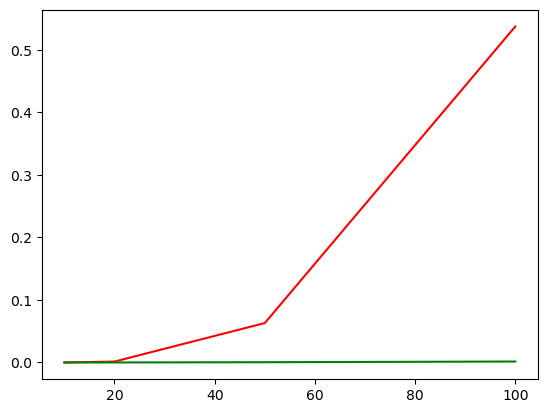

In [46]:
using PythonPlot
plot(N, res_creation[:,1], "r-", N, res_creation[:,4],"g-");

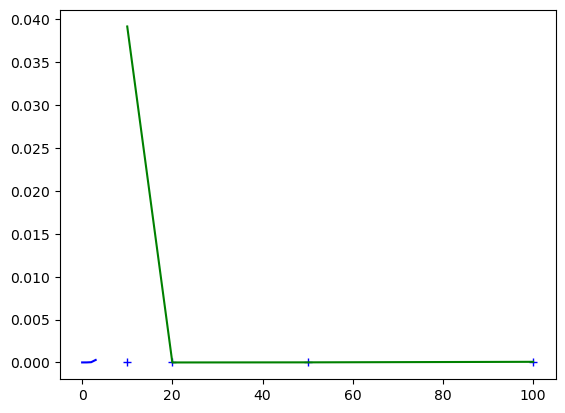

In [47]:
#plot(N, res_execution[:,1], "r-", N, res_execution[:,2], "b-", N, res_execution[:,3], "b+", N, res_execution[:,4],"g-");
plot(res_execution[:,2], "b-", N, res_execution[:,3], "b+", N, res_execution[:,4],"g-");

### Comparaisons des 2 dernières méthodes 

Pour des valeurs de N plus grand, la première méthode `K2D` dépassant rapidement la mémoire on peut se contenter de comparer 
uniquement les deux autres méthodes : pour évaluer le compromis temps de création *vs* temps d'execution, on pourra
tracer par exemple ` 100 * tps_execution + tps_creation ` pour `K2Dₖᵣₑᵤₛₑ` contre `100 * tps_execution` pour `K2Dₗₒₒₚ`

In [48]:
N = [100, 500, 1000]
res_creation = zeros(length(N), 2)
res_execution = zeros(length(N), 2)
for (i, n) in enumerate(N)
    K , res_creation[i,2] = @timed K2Dₖᵣₑᵤₛₑ(n) 
    X = rand(n,n)
    x = vec(X) 
    val, res_execution[i, 1] = @timed K2Dₗₒₒₚ(X)
    val, res_execution[i, 2] = @timed K*x
end

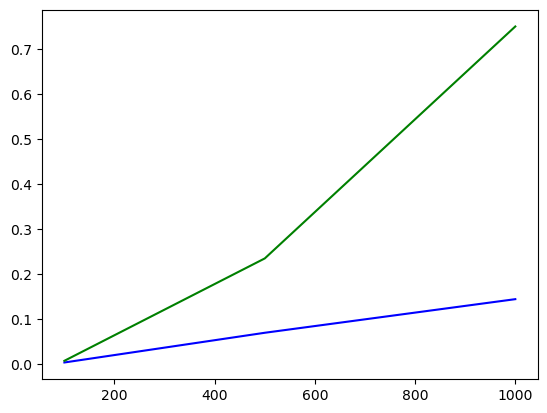

In [49]:
plot(N, 100 * res_execution[:,1], "b-", N, 100*res_execution[:,2]+res_creation[:,2], "g-");

## Boucle temporelle

Maintenant que le laplacien 2D est implémenté on peut résoudre numériquement l'équation de la chaleur avec un schéma
d'Euler explicite en écrivant
$$
U_{n+1} = U_n - \frac{\delta_t}{h^2} K2D_n U_n 
$$
on prendra $h = 1 / N$ et $\delta_t = h^2/4$ <br>
Pour vérifier que le processus d'itération s'arretera bien on pourra comparer l'erreur 
$$
e = \sqrt{\sum_{i,j} \left(U_{n+1}(i,j) - U_{n}(i,j)\right)^2}
$$
avec une précision donnée $\varepsilon = 10^{-4}$
### Questions
   - Initialiser la matrice `Uₙ` avec des zéros partout, sauf sur le bord (on mettra des 1.)
   - Dans le squelette de code donné ci-après, coder l'étape de mise a jour de $U_n$ et le calcul de l'erreur
   - admirer l'animation

In [50]:

function meshGrid(x,y)
    xx = repeat(x; outer=length(y))
    yy = repeat(y; inner=length(x))
    XX = reshape(xx, length(x), length(y))
    YY = reshape(yy, length(x), length(y))    
    XX,YY
end


meshGrid (generic function with 1 method)

it = 62 err = 0.0006218401728097828


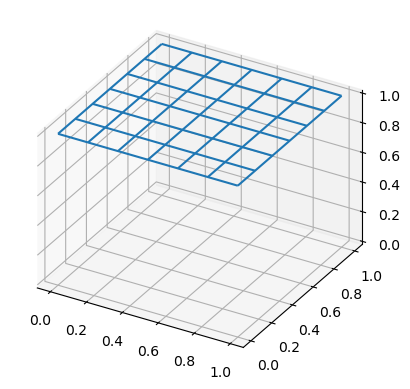

In [64]:
using Printf
KW = Dict{Any, Any}
tmpd = mktempdir()

N = 5
Uₙ = zeros(N + 2,N + 2)
h = 1 / N
Uₙ[1, :] .= 1;
Uₙ[:, 1] .= 1;
Uₙ[end, :] .= 1;
Uₙ[:, end] .= 1;
Uₙ₊₁ = copy(Uₙ);
t, tEnd  = 0, 10.;
prec = 1e-4
err = 2prec
itMax = 1000
it = 0
δₜ = h^2 / 4
x = range(0, 1; length=N+2)
y = range(0, 1; length=N+2)
XX, YY = meshGrid(x,y)
fig, ax = subplots(subplot_kw=KW("projection"=>"3d", "proj_type"=>"ortho"))
while t < tEnd && it < itMax && err > prec
    Uₙ₊₁ -= K2Dₗₒₒₚ(Uₙ) * δₜ / h.^2
    err = √sum((Uₙ₊₁-Uₙ).^2)
    it += 1
    Uₙ = Uₙ₊₁ 
    ax.clear()
    ax.plot_wireframe(XX, YY, Uₙ);
    ax.set_zlim3d(bottom=0., top=1.);
    savefig(joinpath(tmpd, @sprintf("heat_%04d",it)));
end 
println("it = $it err = $(√sum((Uₙ-ones(N+2,N+2)).^2))")


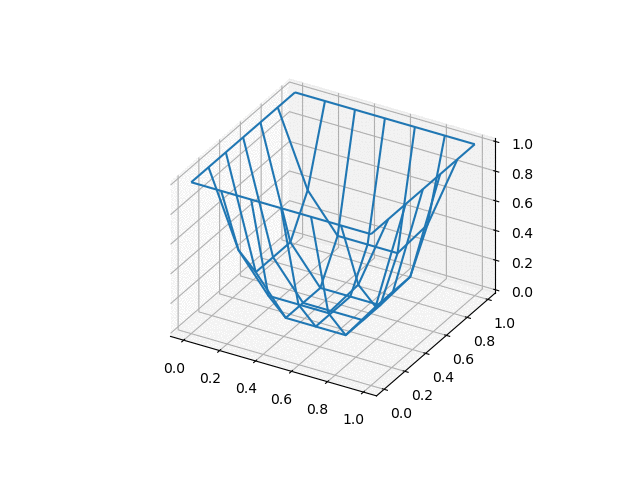

In [65]:
using Base64
function showgif(filename)
    open(filename) do f
        base64_video = base64encode(f)
        display("text/html", """<img src="data:image/gif;base64,$base64_video">""")
    end
end
run(`convert -delay 20 -loop 0 $tmpd/heat_\*.png heat.gif`)
showgif("heat.gif")